<h3>Dependencies

In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, ExpSineSquared, RBF

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.optimize import minimize

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.dates as mdates

from datetime import datetime

### Plotting settings

In [2]:
cm = 1/2.54

fsize = 11
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

style = 'default'

plt.style.use(style)
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 300
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]

### Read data

In [3]:
# Enter the local path of the data file
datapath = "D:\\Eleonora\\code\\data\\fivemin_data.csv"
allData = pd.read_csv(datapath)

allData

,Unnamed: 0,sol altitude,sol azimuth,GHI,DNI,DHI,GHE,cld_ttl_amt_id,air_temperature,dewpoint,rltv_hum,stn_pres,wmo_hr_sun_dur
0,2015-01-01 00:00:00,-62.406026,347.757658,0.0,0.0,0.0,0.0,8.0,11.000000,10.200000,94.900000,1018.900000,0.0
1,2015-01-01 00:05:00,-62.558457,350.224649,0.0,0.0,0.0,0.0,8.0,11.016667,10.208333,94.791667,1018.833333,NaN
2,2015-01-01 00:10:00,-62.676821,352.711677,0.0,0.0,0.0,0.0,8.0,11.033333,10.216667,94.683333,1018.766667,NaN
3,2015-01-01 00:15:00,-62.760652,355.213865,0.0,0.0,0.0,0.0,8.0,11.050000,10.225000,94.575000,1018.700000,NaN
4,2015-01-01 00:20:00,-62.809616,357.726106,0.0,0.0,0.0,0.0,8.0,11.066667,10.233333,94.466667,1018.633333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210523,2016-12-31 23:35:00,-61.101736,335.785536,0.0,0.0,0.0,0.0,7.0,8.800000,7.700000,93.000000,1014.900000,NaN
210524,2016-12-31 23:40:00,-61.414717,338.087436,0.0,0.0,0.0,0.0,7.0,8.800000,7.700000,93.000000,1014.900000,NaN
210525,2016-12-31 23:45:00,-61.697641,340.428336,0.0,0.0,0.0,0.0,7.0,8.800000,7.700000,93.000000,1014.900000,NaN
210526,2016-12-31 23:50:00,-61.949544,342.805318,0.0,0.0,0.0,0.0,7.0,8.800000,7.700000,93.000000,1014.900000,NaN


### Dataframe Index explaination
**sol altitude** : 'solar altitude [degree]',<br>
**sol azimuth** : 'solar azimuth [degree]',<br>
**GHI** : 'global horizontal irradiance [W/m2]',<br>
**DNI** : 'direct normal irradiance [W/m2]',<br>
**DHI** : 'diffuse horizontal irradiance [W/m2]',<br>
**GHE** : 'global horizontal illuminance [lux]',<br>
**cld_ttl_amt_id** : 'total cloud cover [oktas 0-8] (9 for non-meteorological sky cover)',<br>
**air_temperature** : 'air temperature [degree C]',<br>
**dewpoint** : 'dew point temperature [degree C]',<br>
**rltv_hum** : 'relative humidity [%]',<br>
**stn_pres** : 'pressure [hPa]',<br>
**wmo_hr_sun_dur** : 'sunshine duration [hrs]'

### NaN cleanup | Slicing

In [4]:
# Rename certain columns to remove spaces and make them more comprehensive
allData.rename(columns = {'Unnamed: 0':'datetime', 'sol altitude':'sol_alt', 'sol azimuth': 'sol_az'}, inplace = True)

# Drop columns that contain NaN values 
data = allData.drop(labels=["wmo_hr_sun_dur"], axis=1)
data.dropna(inplace=True)

In [5]:
data

,datetime,sol_alt,sol_az,GHI,DNI,DHI,GHE,cld_ttl_amt_id,air_temperature,dewpoint,rltv_hum,stn_pres
0,2015-01-01 00:00:00,-62.406026,347.757658,0.0,0.0,0.0,0.0,8.0,11.000000,10.200000,94.900000,1018.900000
1,2015-01-01 00:05:00,-62.558457,350.224649,0.0,0.0,0.0,0.0,8.0,11.016667,10.208333,94.791667,1018.833333
2,2015-01-01 00:10:00,-62.676821,352.711677,0.0,0.0,0.0,0.0,8.0,11.033333,10.216667,94.683333,1018.766667
3,2015-01-01 00:15:00,-62.760652,355.213865,0.0,0.0,0.0,0.0,8.0,11.050000,10.225000,94.575000,1018.700000
4,2015-01-01 00:20:00,-62.809616,357.726106,0.0,0.0,0.0,0.0,8.0,11.066667,10.233333,94.466667,1018.633333
...,...,...,...,...,...,...,...,...,...,...,...,...
210523,2016-12-31 23:35:00,-61.101736,335.785536,0.0,0.0,0.0,0.0,7.0,8.800000,7.700000,93.000000,1014.900000
210524,2016-12-31 23:40:00,-61.414717,338.087436,0.0,0.0,0.0,0.0,7.0,8.800000,7.700000,93.000000,1014.900000
210525,2016-12-31 23:45:00,-61.697641,340.428336,0.0,0.0,0.0,0.0,7.0,8.800000,7.700000,93.000000,1014.900000
210526,2016-12-31 23:50:00,-61.949544,342.805318,0.0,0.0,0.0,0.0,7.0,8.800000,7.700000,93.000000,1014.900000


In [6]:
data["datetime"] = pd.to_datetime(data["datetime"], format='%Y-%m-%d %H:%M:%S')

In [38]:
df = pd.DataFrame(data)
df['minutes'] = (df['datetime'] - df['datetime'].iloc[0]).dt.total_seconds() / 60
df['minutes']

0               0.0
1               5.0
2              10.0
3              15.0
4              20.0
            ...    
210523    1052615.0
210524    1052620.0
210525    1052625.0
210526    1052630.0
210527    1052635.0
Name: minutes, Length: 207565, dtype: float64

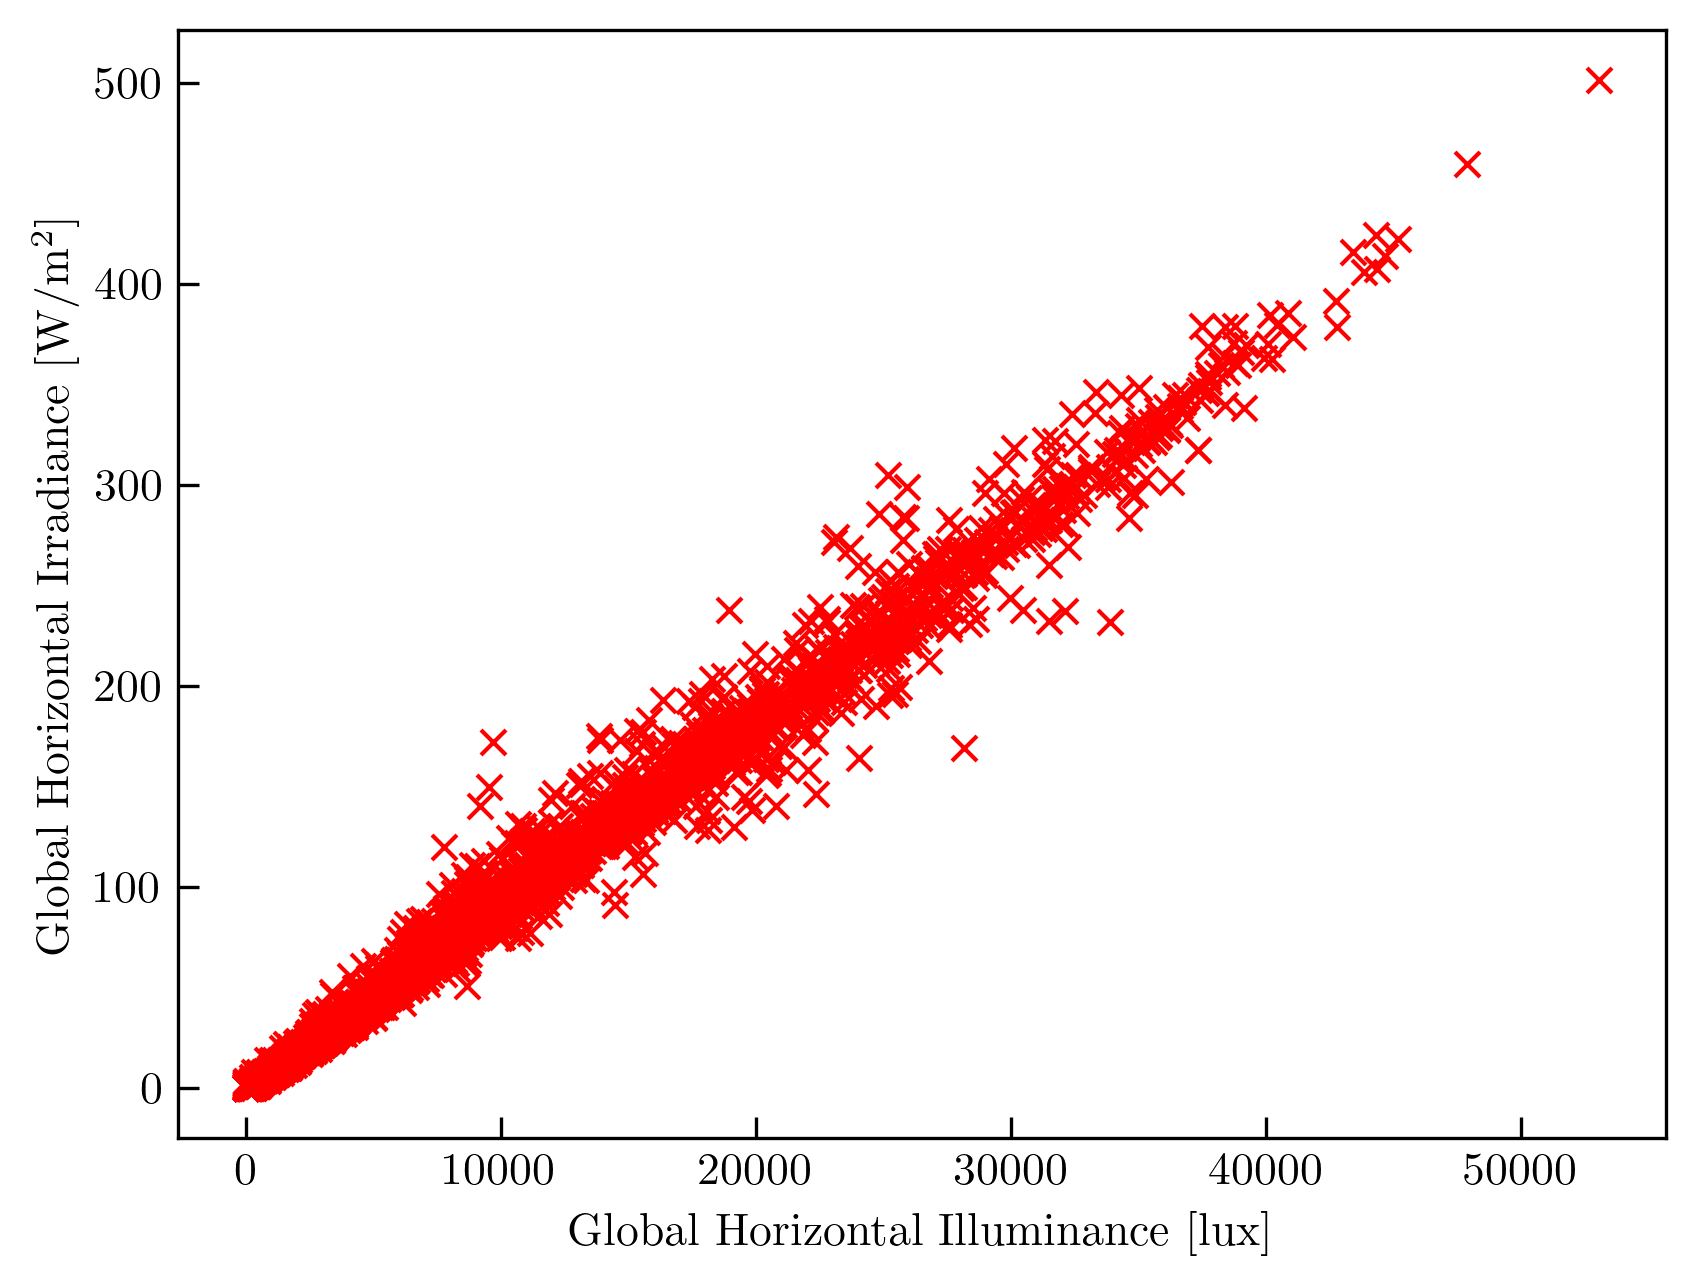

In [8]:
jan2015 = df[(df['datetime'].dt.year == 2015) & (df['datetime'].dt.month == 1)]
firstDay = df[(df['datetime'].dt.year == 2015) & (df['datetime'].dt.month == 1) & (df['datetime'].dt.day == 1)]
# plt.plot(firstDay["datetime"], firstDay["GHI"]);

plt.plot(jan2015["GHE"], jan2015["GHI"], 'rx')
plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')
plt.xlabel('Global Horizontal Illuminance [lux]')

plt.savefig("5minMeasurements.png",bbox_inches='tight')

plt.show()


### Apply GP for one month's forecasting

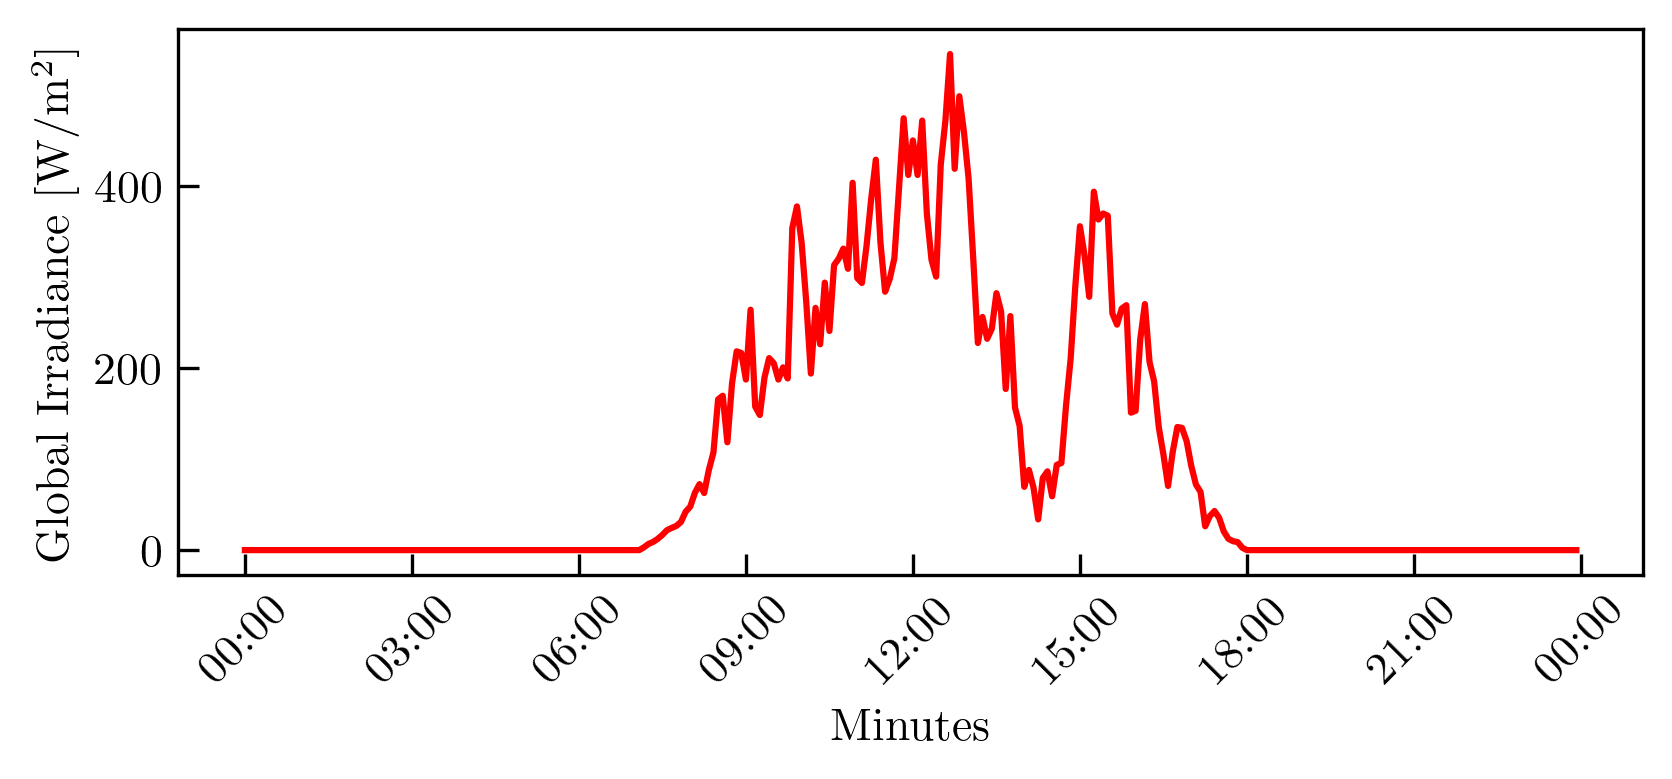

In [68]:
# Choose the year and month of interest
day_cutoff_min = 1
day_cutoff_max = 1
month_key = 3
year_key = 2015

train_data = df[(df['datetime'].dt.year == year_key) & (df['datetime'].dt.month == month_key) & (df['datetime'].dt.day >= day_cutoff_min) & (df['datetime'].dt.day <= day_cutoff_max)]
# jan2015 = df[(df['datetime'].dt.year == 2015) & (df['datetime'].dt.month == 1)]
# firstDay = df[(df['datetime'].dt.year == 2015) & (df['datetime'].dt.month == 1) & (df['datetime'].dt.day == 1)]

# Create the DataFrame
# train_data['datetime'] = pd.to_datetime(train_data['datetime'])

# Set the first element to have a value of zero, and the rest as hours passed after the first element
# train_data['hours'] = (train_data['datetime'] - train_data['datetime'].iloc[0]).dt.total_seconds() / 3600

plt.figure(figsize=(16*cm,6*cm))
plt.plot(train_data['datetime'], train_data['GHI'], c='red')
plt.xlabel('Minutes')
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.ylabel('Global Irradiance [W/m$^2$]')

plt.savefig("firstMarch2015train.png",bbox_inches='tight')

plt.show()

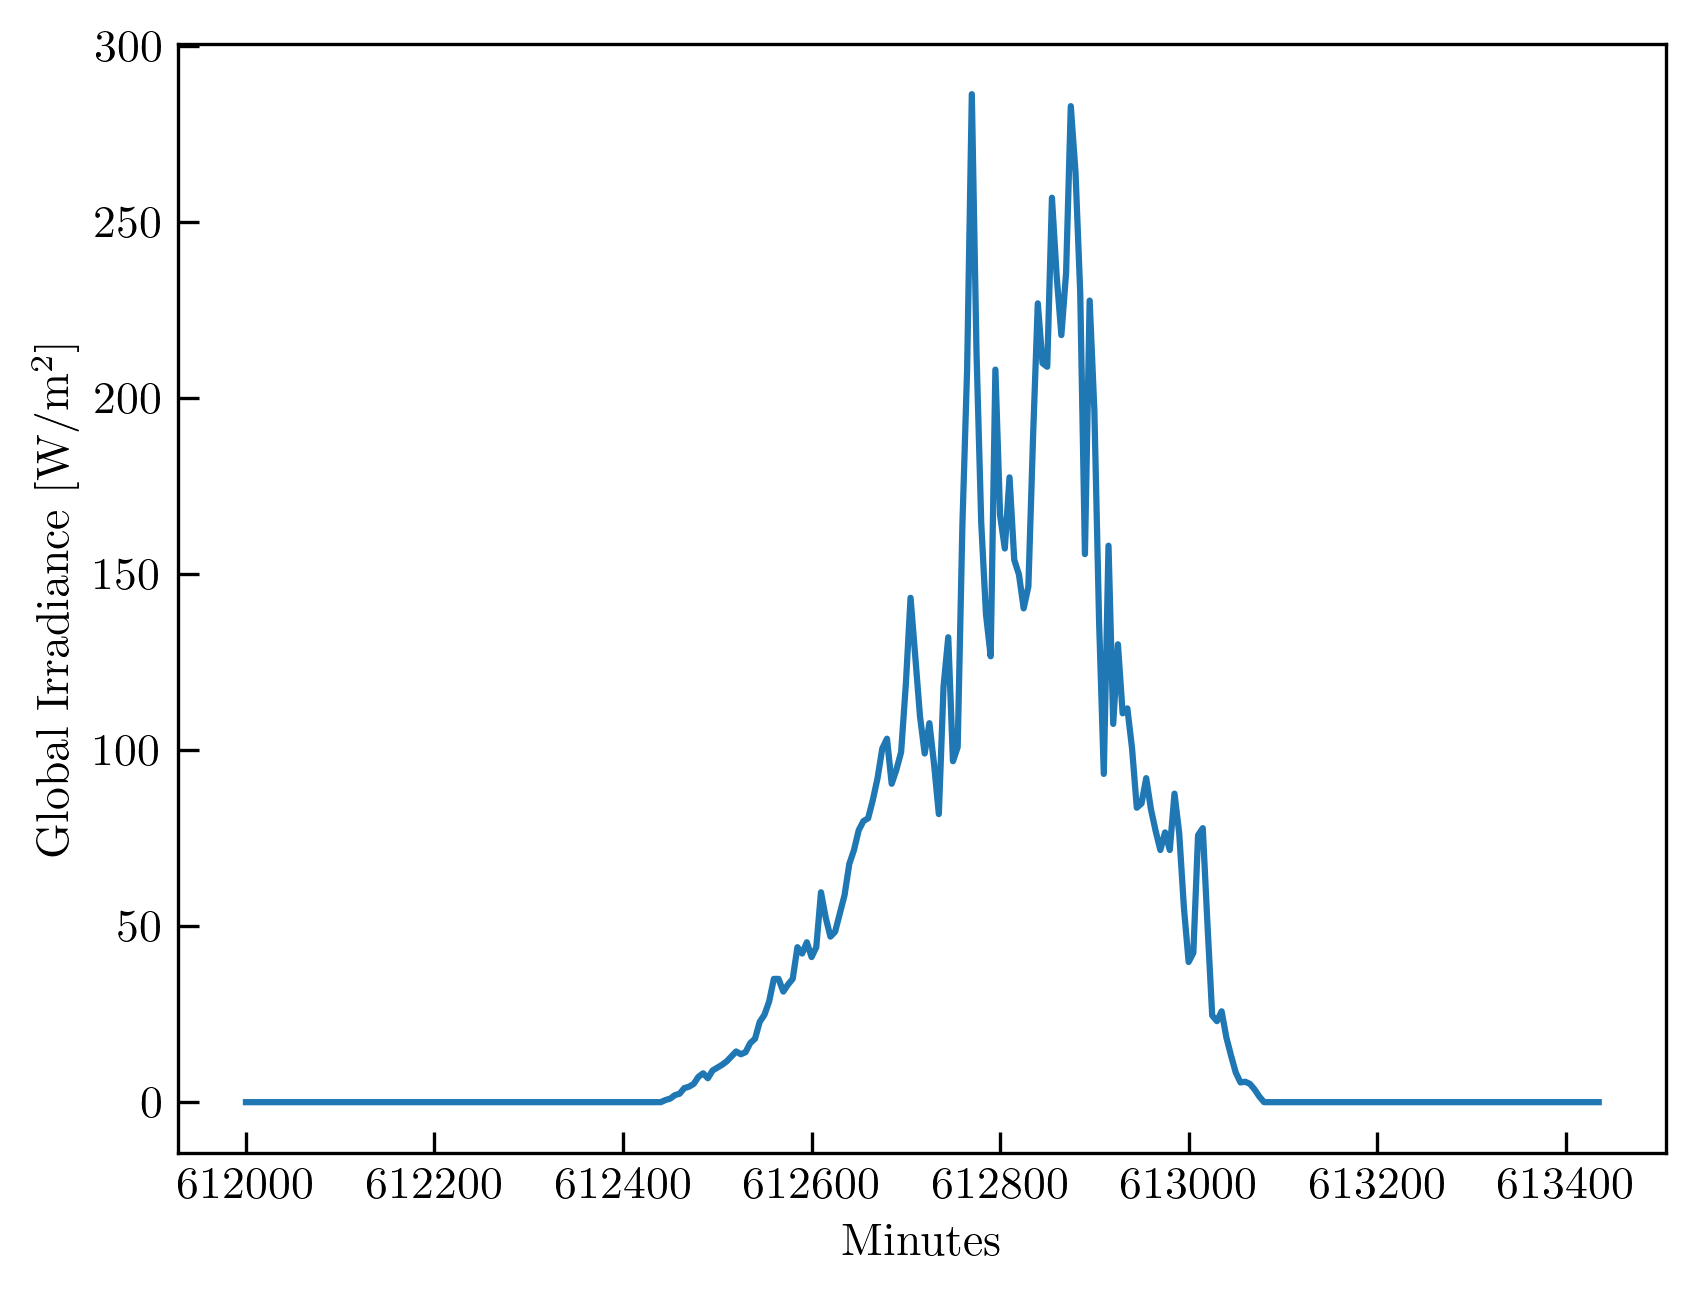

In [39]:
day_cutoff_min = 1
day_cutoff_max = 1
month_key = 3
year_key = 2016

test_data = df[(df['datetime'].dt.year == year_key) & (df['datetime'].dt.month == month_key) & (df['datetime'].dt.day >= day_cutoff_min) & (df['datetime'].dt.day <= day_cutoff_max)]

plt.figure()

plt.plot(test_data['minutes'], test_data['GHI'])
plt.xlabel('Minutes')
plt.ylabel('Global Irradiance [W/m$^2$]')
plt.show()


In [23]:
# train/test split
prop_train = 0.5
n_train = round(prop_train * train_data.shape[0])

# predictors = ["minutes"]
predictors = ["minutes", "GHE"]
# predictors = ["minutes", "GHE", "sol_alt"]
# predictors = ["minutes", "GHE", "sol_alt", "DNI"]
# predictors = ["minutes", "sol_alt", "DNI", "DHI"]
# predictors = ["minutes", "sol_alt", "sol_az", "GHE", "DNI", "DHI"]
# predictors = ["minutes", "GHE", "sol_alt", "sol_az"]
# predictors = ["minutes", "GHE", "sol_alt", "sol_az", "cld_ttl_amt_id"]

X = train_data[predictors].values

y = train_data['GHI'].values
# y = train_data['DHI'].values
# y = train_data['DNI'].values

X_train = X[:n_train]
y_train = y[:n_train][:, np.newaxis]
# X_train = X
# y_train = y[:, np.newaxis]

X_test = test_data[predictors].values
y_test = test_data['GHI'].values
# y_test = test_data['DHI'].values


xScaler = StandardScaler()
yScaler = StandardScaler()
y_train_scaled = yScaler.fit_transform(y_train)
X_train_scaled = xScaler.fit_transform(X_train)

k0 = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-50, 1e10))

k1 = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-10, 1e10)) \
   * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-10, 1e10), periodicity=12*24)
   
nonlinear_kernel = ConstantKernel(constant_value=50.0, constant_value_bounds=(1e-20, 1e20)) * Matern(length_scale=1.0, nu=2.5)
seasonal_kernel = ConstantKernel(constant_value=20.0, constant_value_bounds=(1e-20, 1e20)) * ExpSineSquared(length_scale=1.0, periodicity=12*24, length_scale_bounds=(1e-20, 1e20))
noise_kernel = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-50, 1e50))

kernel = nonlinear_kernel + seasonal_kernel + noise_kernel
# kernel = k0 + k1

gpr = GaussianProcessRegressor(kernel=kernel, alpha=1., n_restarts_optimizer=20)


# Train the GPR model on the training data
gpr.fit(X_train_scaled, y_train_scaled)

# Make predictions
y_pred, y_std = gpr.predict(xScaler.transform(X), return_std=True)

r2score = gpr.score(X=xScaler.transform(X), y=yScaler.transform(y[:, np.newaxis]))
rmse = mean_squared_error(y, yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze(), squared=False)
# nrmse = ((yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze() - y)**2).sum() / (y.size * (y ** 2).sum())
nrmse = rmse / (np.abs(y.max() - y.min()))

print(gpr.kernel_.k1)
print(gpr.kernel_.k2)

print("When using a GAUSSIAN PROCESS")
print(f"R2 score: {r2score:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")








# Train the GPR model on the training data
# gpr.fit(X_train_scaled, y_train_scaled)

# # Make predictions
# y_pred, y_std = gpr.predict(xScaler.transform(X_test), return_std=True)

# r2score = gpr.score(X=xScaler.transform(X_test), y=yScaler.transform(y_test[:, np.newaxis]))
# rmse = mean_squared_error(y_test, yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze(), squared=False)
# nrmse = rmse / (np.abs(y_test.max() - y_test.min()))

# print(gpr.kernel_.k1)
# print(gpr.kernel_.k2)

# print("When using a GAUSSIAN PROCESS")
# print(f"R2 score: {r2score:.3f}")
# print(f"Root Mean Squared Error: {rmse:.3f}")
# print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")

2.54**2 * Matern(length_scale=6.36, nu=2.5) + 1.35e-07**2 * ExpSineSquared(length_scale=3.1e+07, periodicity=1.97e-05)
WhiteKernel(noise_level=7.06e-20)
When using a GAUSSIAN PROCESS
R2 score: 0.771
Root Mean Squared Error: 67.115
Normalized Root Mean Squared Error: 0.123011


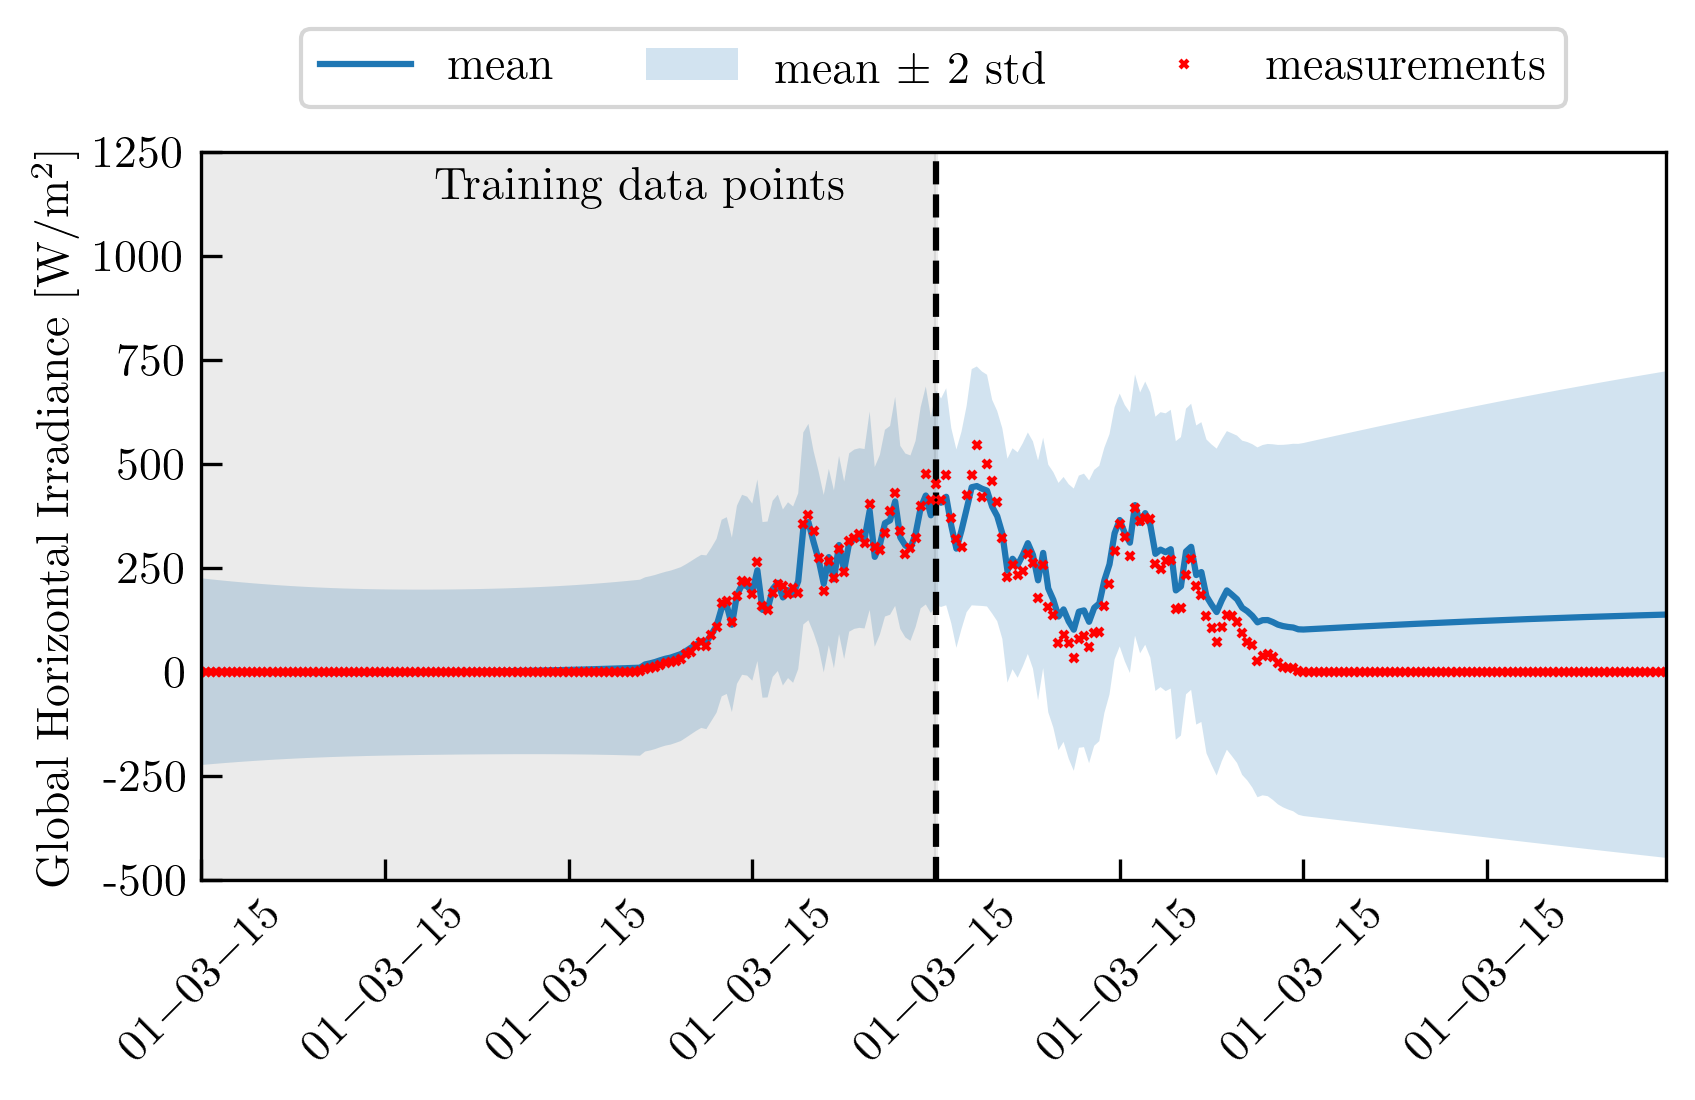

In [24]:
dates = train_data["datetime"].values
plt.figure(figsize=(16*cm,8*cm))
plt.plot(dates, yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze(), label="mean")
plt.fill_between(dates,
                 yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze() + 2 * yScaler.inverse_transform(y_std[:, np.newaxis]).squeeze(),
                 yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze() - 2 * yScaler.inverse_transform(y_std[:, np.newaxis]).squeeze(), 
                 alpha=0.2, 
                 label=r'mean $\pm$ 2 std')
plt.axvspan(dates[0], dates[n_train], alpha=0.08, color='k')
plt.axvline(dates[n_train], linestyle='--', c='k')
# plt.plot(dates, lin_pred, label="Linear Regression")
plt.plot(dates, y, 'rx', markersize=2., label='measurements')

plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')
# plt.ylabel('Diffuse Horizontal Irradiance [W/m$^2$]')
# plt.ylabel('Direct Normal Irradiance [W/m$^2$]')
plt.xlim((dates[0], dates[-1]))
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=3)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
# ax.set_yticks(np.arange(-750, 1751, 500),np.arange(-750, 1751, 500))
ax.set_yticks(np.arange(-500, 1251, 250),np.arange(-500, 1251, 250))
plt.ylim((-500, 1250))

plt.text(0.3, 0.95, "Training data points", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
# plt.text(0.86, 0.95, "Forecasting", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

# plt.savefig("monthForecastGHI_morePredictors.png",bbox_inches='tight')

plt.show()

### Linear Regression

In [37]:
# X_lin = train_data["GHE"].values[:, np.newaxis]
# y_lin = train_data['GHI'].values
X_lin = train_data[predictors].values
y_lin = train_data['DHI'].values

# X_train_lin = X_lin[:n_train]
# y_train_lin = y_lin[:n_train]
X_train_lin = X_lin
y_train_lin = y_lin

reg = LinearRegression().fit(X_train_lin, y_train_lin)
lin_pred = reg.predict(X_test)

r2score = reg.score(X_test, y_test)
rmse = mean_squared_error(y_test, lin_pred, squared=False)
# nrmse = ((lin_pred - y_lin)**2).sum() / (lin_pred.size * (y_lin ** 2).sum())
nrmse = rmse / (np.abs(lin_pred.max() - lin_pred.min()))

print("When using LINEAR REGRESSION")
print(f"R2 score: {r2score:.3f}")
print(f"Mean Squared Error: {rmse:.3f}")
print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")

When using LINEAR REGRESSION
R2 score: -11.235
Mean Squared Error: 250.600
Normalized Root Mean Squared Error: 0.621005


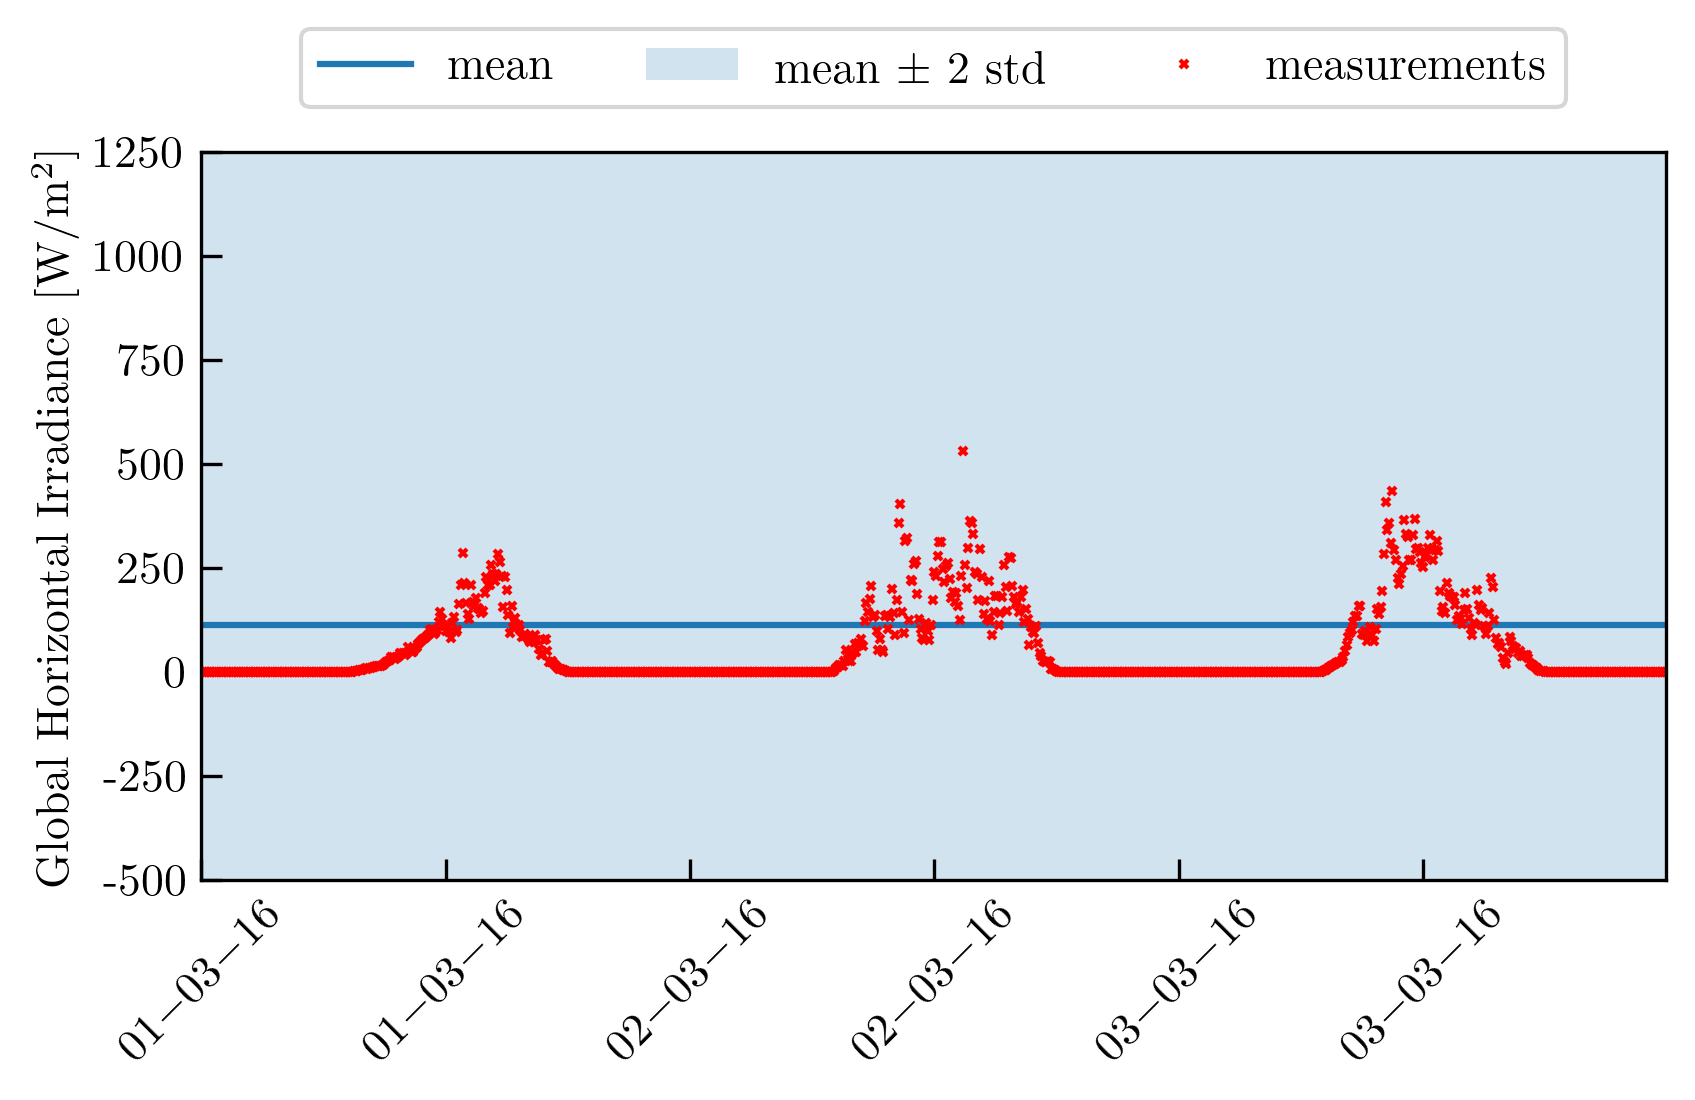

In [12]:
dates = test_data["datetime"].values
plt.figure(figsize=(16*cm,8*cm))
plt.plot(dates, yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze(), label="mean")
# plt.plot(dates, lin_pred, label="Linear")
plt.fill_between(dates,
                 yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze() + 2 * yScaler.inverse_transform(y_std[:, np.newaxis]).squeeze(),
                 yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze() - 2 * yScaler.inverse_transform(y_std[:, np.newaxis]).squeeze(), 
                 alpha=0.2, 
                 label=r'mean $\pm$ 2 std')
# plt.axvspan(dates[0], dates[n_train], alpha=0.08, color='k')
# plt.axvline(dates[n_train], linestyle='--', c='k')
# plt.plot(dates, lin_pred, label="Linear Regression")
plt.plot(dates, y_test, 'rx', markersize=2., label='measurements')

plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')
# plt.ylabel('Diffuse Horizontal Irradiance [W/m$^2$]')
# plt.ylabel('Direct Normal Irradiance [W/m$^2$]')
plt.xlim((dates[0], dates[-1]))
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=3)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
# ax.set_yticks(np.arange(-750, 1751, 500),np.arange(-750, 1751, 500))
ax.set_yticks(np.arange(-500, 1251, 250),np.arange(-500, 1251, 250))
plt.ylim((-500, 1250))

# plt.text(0.3, 0.95, "Training data points", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
# plt.text(0.86, 0.95, "Forecasting", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

# plt.savefig("monthForecastGHI_5min.png",bbox_inches='tight')
plt.savefig("monthForecastGHI_5min_trainStart_testEnd.png",bbox_inches='tight')

plt.show()

In [ ]:
dates = train_data["datetime"].values
plt.figure(figsize=(16*cm,8*cm))
plt.plot(dates, yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze(), label="mean")
plt.fill_between(dates,
                 yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze() + 2 * yScaler.inverse_transform(y_std[:, np.newaxis]).squeeze(),
                 yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze() - 2 * yScaler.inverse_transform(y_std[:, np.newaxis]).squeeze(), 
                 alpha=0.2, 
                 label=r'mean $\pm$ 2 std')
plt.axvspan(dates[0], dates[n_train], alpha=0.08, color='k')
plt.axvline(dates[n_train], linestyle='--', c='k')
# plt.plot(dates, lin_pred, label="Linear Regression")
plt.plot(dates, y, 'rx', markersize=2., label='measurements')

# plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')
plt.ylabel('Diffuse Horizontal Irradiance [W/m$^2$]')
# plt.ylabel('Direct Normal Irradiance [W/m$^2$]')
plt.xlim((dates[0], dates[-1]))
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=3)
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
# ax.set_yticks(np.arange(-750, 1751, 500),np.arange(-750, 1751, 500))
ax.set_yticks(np.arange(-500, 1251, 250),np.arange(-500, 1251, 250))
plt.ylim((-250, 500))
plt.xlim([datetime.date(2015, 3, 1), datetime.date(2015, 3, 31)])

plt.text(0.3, 0.95, "Training data points", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
# plt.text(0.86, 0.95, "Forecasting", horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

plt.savefig("monthForecastDHI_morePredictors.png",bbox_inches='tight')

plt.show()

In [ ]:
plotX = X_lin[:,1].squeeze()
plotY = y_lin

plt.figure(figsize=(8*cm,8*cm))
plt.plot(plotX, plotY, 'rx', markersize=2., label="mean")

plt.xlabel('Global Horizontal Illuminance [lux]')
plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')

ax = plt.gca()
ax.set_xticks(np.arange(0, 80001, 20000),np.arange(0, 80001, 20000))
ax.set_yticks(np.arange(0, 801, 200),np.arange(0, 801, 200))

plt.xlim((0, 80000))
plt.ylim((0, 800))

# plt.savefig("measurementLinearPlot.png",bbox_inches='tight')

plt.show()

### Train GP on sunniest and least sunny months of 2015, and forecast for whole 2016

In [ ]:
four_month_data = pd.concat((pd.concat((nested_data[2015][month][day] for day in range(1, 31))) for month in (3, 6, 9, 12)))
two_month_data = pd.concat((pd.concat((nested_data[2015][month][day] for day in range(1, 31))) for month in (6, 12)))
one_month_data = pd.concat((pd.concat((nested_data[2015][month][day] for day in range(1, 31))) for month in (12,)))

# Create the DataFrame
# two_month_data['datetime'] = pd.to_datetime(two_month_data['datetime'])
# one_month_data['datetime'] = pd.to_datetime(one_month_data['datetime'])
# four_month_data['datetime'] = pd.to_datetime(four_month_data['datetime'])

# # Set the first element to have a value of zero, and the rest as hours passed after the first element
# two_month_data['hours'] = (two_month_data['datetime'] - two_month_data['datetime'].iloc[0]).dt.total_seconds() / 3600
# one_month_data['hours'] = (one_month_data['datetime'] - one_month_data['datetime'].iloc[0]).dt.total_seconds() / 3600
# four_month_data['hours'] = (four_month_data['datetime'] - four_month_data['datetime'].iloc[0]).dt.total_seconds() / 3600

plt.figure(figsize=(16*cm,8*cm))
test_dates = two_month_data["datetime"].values
plt.plot(test_dates, two_month_data['GHI'], c='r')

plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')

ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

ax.set_yticks(np.arange(0, 1001, 250),np.arange(0, 1001, 250))
plt.ylim((0, 1000))
plt.xlim([datetime.date(2015, 6, 1), datetime.date(2015, 12, 31)])

plt.savefig("trainData2015.png",bbox_inches='tight')

plt.show()


### GP without constraints

In [25]:
# predictors = ["hours"]
predictors = ["minutes", "GHE"]
# predictors = ["hours", "GHE", "sol_alt"]
# predictors = ["hours", "GHE", "sol_alt", "sol_az"]

targets = ["GHI"]
# targets = ["DHI"]
# targets = ["DHI", "DNI"]

X_train = train_data[predictors].values
y_train = train_data[targets].values

xScaler = StandardScaler()
yScaler = StandardScaler()
y_train_scaled = yScaler.fit_transform(y_train)
X_train_scaled = xScaler.fit_transform(X_train)

k0 = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-50, 1e10))

k1 = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-10, 1e10)) \
   * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-10, 1e10), periodicity=24)
   
# kernel = k0 + k1

nonlinear_kernel = ConstantKernel(constant_value=50.0, constant_value_bounds=(1e-20, 1e20)) * Matern(length_scale=1.0, nu=2.5)
seasonal_kernel = ConstantKernel(constant_value=20.0, constant_value_bounds=(1e-20, 1e20)) * ExpSineSquared(length_scale=1.0, periodicity=12*24, length_scale_bounds=(1e-20, 1e20))
noise_kernel = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-50, 1e50))

kernel = nonlinear_kernel + seasonal_kernel + noise_kernel

gpr = GaussianProcessRegressor(kernel=kernel, alpha=1., n_restarts_optimizer=10)

# Train the GPR model on the training data
gpr.fit(X_train_scaled, y_train_scaled)

c:\Users\Mr. Christos\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-20. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=1.0,
                         kernel=7.07**2 * Matern(length_scale=1, nu=2.5) + 4.47**2 * ExpSineSquared(length_scale=1, periodicity=288) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=10)

### Single month (of 2016) plotting

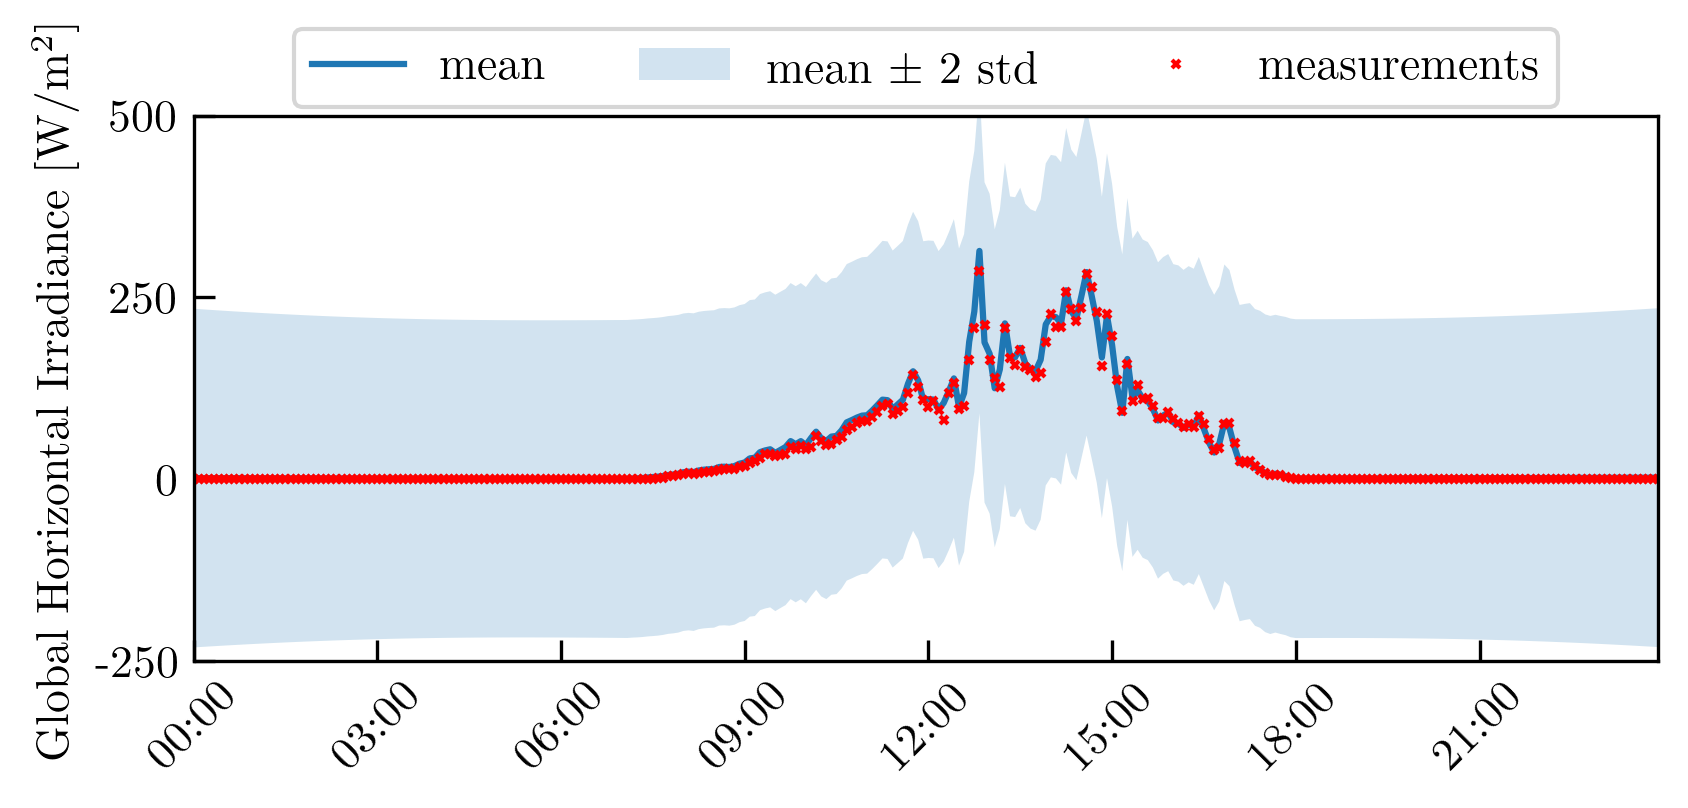

In [65]:
# single_month = 12

# test_data = pd.concat((nested_data[2016][single_month][day] for day in range(1, 30)))

# Create the DataFrame
# test_data['datetime'] = pd.to_datetime(test_data['datetime'])

# Set the first element to have a value of zero, and the rest as hours passed after the first element
# test_data['hours'] = (test_data['datetime'] - test_data['datetime'].iloc[0]).dt.total_seconds() / 3600

test_X = test_data[predictors].values
test_y = test_data[targets].values
# test_X = train_data[predictors].values
# test_y = train_data[targets].values

y_pred_test, y_std_test = gpr.predict(xScaler.transform(test_X), return_std=True)

if y_pred_test.ndim == 1:
    y_pred_rescale = yScaler.inverse_transform(y_pred_test.reshape(-1, 1))
    y_std_rescale = yScaler.inverse_transform(y_std_test.reshape(-1, 1))
elif y_pred_test.ndim == 2:
    y_pred_rescale = yScaler.inverse_transform(y_pred_test)
    y_std_rescale = yScaler.inverse_transform(y_std_test)

test_dates = train_data["datetime"].values

plt.figure(figsize=(16*cm,6*cm))
plt.plot(test_dates, y_pred_rescale[:, 0], label="mean")
plt.fill_between(test_dates,
                 y_pred_rescale[:, 0] + 2 * y_std_rescale[:, 0], 
                 y_pred_rescale[:, 0] - 2 * y_std_rescale[:, 0], 
                 alpha=0.2, 
                 label=r'mean $\pm$ 2 std')
plt.plot(test_dates, test_y[:, 0], 'rx', markersize=2., label='measurements')
plt.ylabel('Global Horizontal Irradiance [W/m$^2$]')
plt.legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=3)
plt.xlim((test_dates[0], test_dates[-1]))

ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_yticks(np.arange(-750, 1001, 250),np.arange(-750, 1001, 250))
plt.ylim((-250, 500))

plt.savefig("sameDayDiffYear.png",bbox_inches='tight')  

plt.show()

In [58]:
test_y.shape

(288, 1)

In [59]:
r2score = gpr.score(X=xScaler.transform(test_X), y=yScaler.transform(test_y))
rmse = mean_squared_error(test_y, yScaler.inverse_transform(y_pred_test[:, np.newaxis]).squeeze(), squared=False)
# nrmse = ((yScaler.inverse_transform(y_pred[:, np.newaxis]).squeeze() - y)**2).sum() / (y.size * (y ** 2).sum())
nrmse = rmse / (np.abs(test_y.max() - test_y.min()))

# print(gpr.kernel_.k1)
# print(gpr.kernel_.k2)

print("When using a GAUSSIAN PROCESS")
print(f"R2 score: {r2score:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")

When using a GAUSSIAN PROCESS
R2 score: 0.992
Root Mean Squared Error: 5.828
Normalized Root Mean Squared Error: 0.020362


### Calculate metrics

In [ ]:
r2score = gpr.score(X=xScaler.transform(test_X), y=yScaler.transform(test_y))
mse = mean_squared_error(test_y.squeeze(), yScaler.inverse_transform(y_pred_test[:, np.newaxis]).squeeze())
nrmse = ((yScaler.inverse_transform(y_pred_test[:, np.newaxis]).squeeze() - test_y.squeeze())**2).sum() / (test_y.squeeze() ** 2).sum()

print(f"R2 score: {r2score:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")

### Whole 2016 forecasting

In [ ]:
# Define the number of days and hours
num_months = 12
n_rows = 4
n_cols = 3

# Create a 5 by 6 grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16*cm, 20*cm), sharey=True, sharex=True)
# fig.suptitle('Forecasting on 2016', fontsize=2*fsize)



for month in range(num_months):
    test_data = pd.concat((nested_data[2016][month+1][day] for day in range(1, 30)))

    # Create the DataFrame
    test_data['datetime'] = pd.to_datetime(test_data['datetime'])

    # Set the first element to have a value of zero, and the rest as hours passed after the first element
    test_data['hours'] = (test_data['datetime'] - test_data['datetime'].iloc[0]).dt.total_seconds() / 3600

    test_X = test_data[predictors].values
    test_y = test_data[targets].values

    y_pred_test, y_std_test = gpr.predict(xScaler.transform(test_X), return_std=True)
    
    if y_pred_test.ndim == 1:
        y_pred_rescale = yScaler.inverse_transform(y_pred_test.reshape(-1, 1))
        y_std_rescale = yScaler.inverse_transform(y_std_test.reshape(-1, 1))
    elif y_pred_test.ndim == 2:
        y_pred_rescale = yScaler.inverse_transform(y_pred_test)
        y_std_rescale = yScaler.inverse_transform(y_std_test)

    test_dates = np.array(test_X[:, 0], dtype=float)
    
    axs[month//n_cols, month%n_cols].plot(test_dates, y_pred_rescale[:, 0], label="mean")
    axs[month//n_cols, month%n_cols].fill_between(test_dates,
                                                  y_pred_rescale[:, 0] + 2 * y_std_rescale[:, 0], 
                                                  y_pred_rescale[:, 0] - 2 * y_std_rescale[:, 0], 
                                                  alpha=0.2, 
                                                  label=r'mean $\pm$ 2 std')
    axs[month//n_cols, month%n_cols].plot(test_dates, test_y[:, 0], 'rx', markersize=2., label='measurements')
    axs[month//n_cols, month%n_cols].title.set_text(months[month])
    axs[month//n_cols, month%n_cols].title.set_size(fsize)

axs[0, 0].set_ylabel('Irradiance [W/m$^2$]')
axs[1, 0].set_ylabel('Irradiance [W/m$^2$]')
axs[2, 0].set_ylabel('Irradiance [W/m$^2$]')
axs[3, 0].set_ylabel('Irradiance [W/m$^2$]')
axs[3, 0].set_xlabel('Time [hours]')
axs[3, 1].set_xlabel('Time [hours]')
axs[3, 2].set_xlabel('Time [hours]')

# Adjust layout to avoid overlap of titles and labels
axs[0, 1].legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(0.5, 1.35), ncols=3)
plt.subplots_adjust(top=0.92)

# plt.savefig("whole2016.png",bbox_inches='tight')

plt.show()


In [ ]:
# Define the number of days and hours
num_months = 4
n_rows = 2
n_cols = 2

# Create a 5 by 6 grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16*cm, 16*cm))

for month in range(num_months):
    test_data = pd.concat((nested_data[2016][month * (len(months) // num_months) +1][day] for day in range(1, 31)))

    # Create the DataFrame
    test_data['datetime'] = pd.to_datetime(test_data['datetime'])

    # Set the first element to have a value of zero, and the rest as hours passed after the first element
    test_data['hours'] = (test_data['datetime'] - test_data['datetime'].iloc[0]).dt.total_seconds() / 3600

    test_X = test_data[predictors].values
    test_y = test_data[targets].values

    y_pred_test, y_std_test = gpr.predict(xScaler.transform(test_X), return_std=True)
    
    if y_pred_test.ndim == 1:
        y_pred_rescale = yScaler.inverse_transform(y_pred_test.reshape(-1, 1))
        y_std_rescale = yScaler.inverse_transform(y_std_test.reshape(-1, 1))
    elif y_pred_test.ndim == 2:
        y_pred_rescale = yScaler.inverse_transform(y_pred_test)
        y_std_rescale = yScaler.inverse_transform(y_std_test)

    test_dates = np.array(test_X[:, 0], dtype=float)
    test_dates = test_data["datetime"].values
    axs[month//n_cols, month%n_cols].plot(test_dates, y_pred_rescale[:, 0], label="mean")
    axs[month//n_cols, month%n_cols].fill_between(test_dates,
                                                  y_pred_rescale[:, 0] + 2 * y_std_rescale[:, 0], 
                                                  y_pred_rescale[:, 0] - 2 * y_std_rescale[:, 0], 
                                                  alpha=0.2, 
                                                  label=r'mean $\pm$ 2 std')
    axs[month//n_cols, month%n_cols].plot(test_dates, test_y[:, 0], 'rx', markersize=2., label='measurements')
    axs[month//n_cols, month%n_cols].set_xlim((test_dates[0], test_dates[-1]))
    axs[month//n_cols, month%n_cols].tick_params(axis='x', rotation=45)
    axs[month//n_cols, month%n_cols].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    axs[month//n_cols, month%n_cols].title.set_size(fsize)

axs[0, 0].set_ylabel('Irradiance [W/m$^2$]')
axs[1, 0].set_ylabel('Irradiance [W/m$^2$]')

axs[0,0].set_yticks(np.arange(-400, 601, 200),np.arange(-400, 601, 200))
axs[0,0].set_ylim((-400, 600))
axs[0,1].set_yticks(np.arange(-500, 1251, 250),np.arange(-500, 1251, 250))
axs[0,1].set_ylim((-500, 1250))
axs[1,0].set_yticks(np.arange(-500, 1251, 250),np.arange(-500, 1251, 250))
axs[1,0].set_ylim((-500, 1250))
axs[1,1].set_yticks(np.arange(-400, 1001, 200),np.arange(-400, 1001, 200))
axs[1,1].set_ylim((-400, 1000))

# Adjust layout to avoid overlap of titles and labels
axs[0, 1].legend(fontsize=fsize, loc='upper center', bbox_to_anchor=(-0.1, 1.18), ncols=3)
plt.subplots_adjust(top=0.92)

# plt.savefig("whole2016.png",bbox_inches='tight')

plt.show()


### GP yearly forecasting error 

In [ ]:
whole2016data = pd.concat((pd.concat((nested_data[2016][month][day] for day in range(1, 30))) for month in range(1, 13)))

whole2016data['datetime'] = pd.to_datetime(whole2016data['datetime'])

# Set the first element to have a value of zero, and the rest as hours passed after the first element
whole2016data['hours'] = (whole2016data['datetime'] - whole2016data['datetime'].iloc[0]).dt.total_seconds() / 3600

test_X = whole2016data[predictors].values
test_y = whole2016data[targets].values

y_pred_test, y_std_test = gpr.predict(xScaler.transform(test_X), return_std=True)

r2score = gpr.score(X=xScaler.transform(test_X), y=yScaler.transform(test_y))
mse = mean_squared_error(test_y, y_pred_test)
nrmse = ((y_pred_test - test_y.squeeze())**2).sum() / (test_y.squeeze() ** 2).sum()

print(f"R2 score: {r2score:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")

### Correlation between Irradiance and Illuminance per month

In [ ]:
monthData = {'Month': months,
             'Max Illum': np.zeros_like(months),
             'Slope': np.zeros_like(months),
             'Intercept': np.zeros_like(months)}

monthlyIllumIrrad = pd.DataFrame(monthData)

plt.figure()
for month_i, month in enumerate(months):
    tempDf = pd.concat((nested_data[2016][month_i + 1][day] for day in range(1, 30)))
    illum = tempDf['GHE'].values
    irrad = tempDf['GHI'].values
    reg = LinearRegression().fit(illum[:, np.newaxis], irrad)
    monthlyIllumIrrad.iloc[month_i, 1:] = np.array([illum.max(), reg.coef_.item(), reg.intercept_])
    sortInds = illum.argsort(axis=0)
    illum = illum[sortInds]
    irrad = irrad[sortInds]
    plt.plot(illum, irrad, label=month)
plt.legend(fontsize=fsize)
plt.show()

monthlyIllumIrrad

### Linear regression trained on limited months

In [ ]:
illum = two_month_data['GHE'].values
irrad = two_month_data['GHI'].values
reg = LinearRegression().fit(illum[:, np.newaxis], irrad)

lin_pred = reg.predict(whole2016data["GHE"].values[:, np.newaxis])

r2score = reg.score(whole2016data["GHE"].values[:, np.newaxis], whole2016data["GHI"].values[:, np.newaxis])
mse = mean_squared_error(whole2016data["GHI"].values.squeeze(), lin_pred)
nrmse = ((lin_pred - whole2016data["GHI"].values.squeeze())**2).sum() / (whole2016data["GHI"].values.squeeze() ** 2).sum()

print(f"R2 score: {r2score:.3f}")   
print(f"Mean Squared Error: {mse:.3f}")
print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")

In [ ]:
single_month = 5

test_data = pd.concat((nested_data[2016][single_month][day] for day in range(1, 30)))

# Create the DataFrame
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

# Set the first element to have a value of zero, and the rest as hours passed after the first element
test_data['hours'] = (test_data['datetime'] - test_data['datetime'].iloc[0]).dt.total_seconds() / 3600

test_X = test_data[predictors].values
test_y = test_data[targets].values

y_pred_test, y_std_test = gpr.predict(xScaler.transform(test_X), return_std=True)

lin_pred = reg.predict(test_data["GHE"].values[:, np.newaxis])

if y_pred_test.ndim == 1:
    y_pred_rescale = yScaler.inverse_transform(y_pred_test.reshape(-1, 1))
    y_std_rescale = yScaler.inverse_transform(y_std_test.reshape(-1, 1))
elif y_pred_test.ndim == 2:
    y_pred_rescale = yScaler.inverse_transform(y_pred_test)
    y_std_rescale = yScaler.inverse_transform(y_std_test)

test_dates = np.array(test_X[:, 0], dtype=float)

plt.figure(figsize=(16*cm,8*cm))
plt.fill_between(test_dates,
                 y_pred_rescale[:, 0] + 2 * y_std_rescale[:, 0], 
                 y_pred_rescale[:, 0] - 2 * y_std_rescale[:, 0], 
                 alpha=0.2, 
                 label=r'mean $\pm$ 2 std')
plt.plot(test_dates, y_pred_rescale[:, 0], label="Gaussian Process")
plt.plot(test_dates, lin_pred, label="Linear Regression")
plt.plot(test_dates, test_y[:, 0], 'rx', markersize=2., label='measurements')
plt.ylabel('Irradiance [W/m$^2$]')
plt.xlabel('Time [hours]')
plt.title(f'Forecasting for {months[single_month-1]} 2016')
plt.legend(fontsize=fsize)
plt.show()

### Gaussian Process

In [ ]:
r2score = gpr.score(X=xScaler.transform(test_X), y=yScaler.transform(test_y))
mse = mean_squared_error(test_y.squeeze(), yScaler.inverse_transform(y_pred_test[:, np.newaxis]).squeeze())
nrmse = ((yScaler.inverse_transform(y_pred_test[:, np.newaxis]).squeeze() - test_y.squeeze())**2).sum() / (test_y.squeeze() ** 2).sum()

print(f"R2 score: {r2score:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")

### Linear Regression

In [ ]:
r2score = reg.score(test_data["GHE"].values[:, np.newaxis], test_data["GHI"].values)
mse = mean_squared_error(test_y.squeeze(), lin_pred)
nrmse = ((lin_pred - test_y.squeeze())**2).sum() / (test_y.squeeze() ** 2).sum()

print(f"R2 score: {r2score:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Normalized Root Mean Squared Error: {nrmse:.6f}")

### Irradiance components constraint evaluation

In [ ]:
df = pd.concat((nested_data[2016][6][day] for day in range(1, 30)))
df["sol_alt"] = pd.to_numeric(df["sol_alt"], errors="coerce")

plt.figure()
plt.plot([0, 1000], [0, 1000], 'k', alpha=0.5)
plt.plot(df["GHI"], df["DNI"].values * np.sin(df["sol_alt"].values * np.pi / 180) + df["DHI"].values, 'bo', markersize=1.0)
plt.show()